In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import preliz as pz

In [2]:
az.style.use("arviz-grayscale")
from cycler import cycler
default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc('axes', prop_cycle=default_cycler)
plt.rc('figure', dpi=300)

In [3]:
np.random.seed(123)
trials = 4
theta_real = 0.35 # unknown value in a real experiment
data = pz.Binomial(n=1, p=theta_real).rvs(trials)
data

array([1, 0, 0, 0])

In [4]:
with pm.Model() as our_first_model:
    θ = pm.Beta('θ', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=θ, observed=data)
    idata = pm.sample(1000, random_seed=4591)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


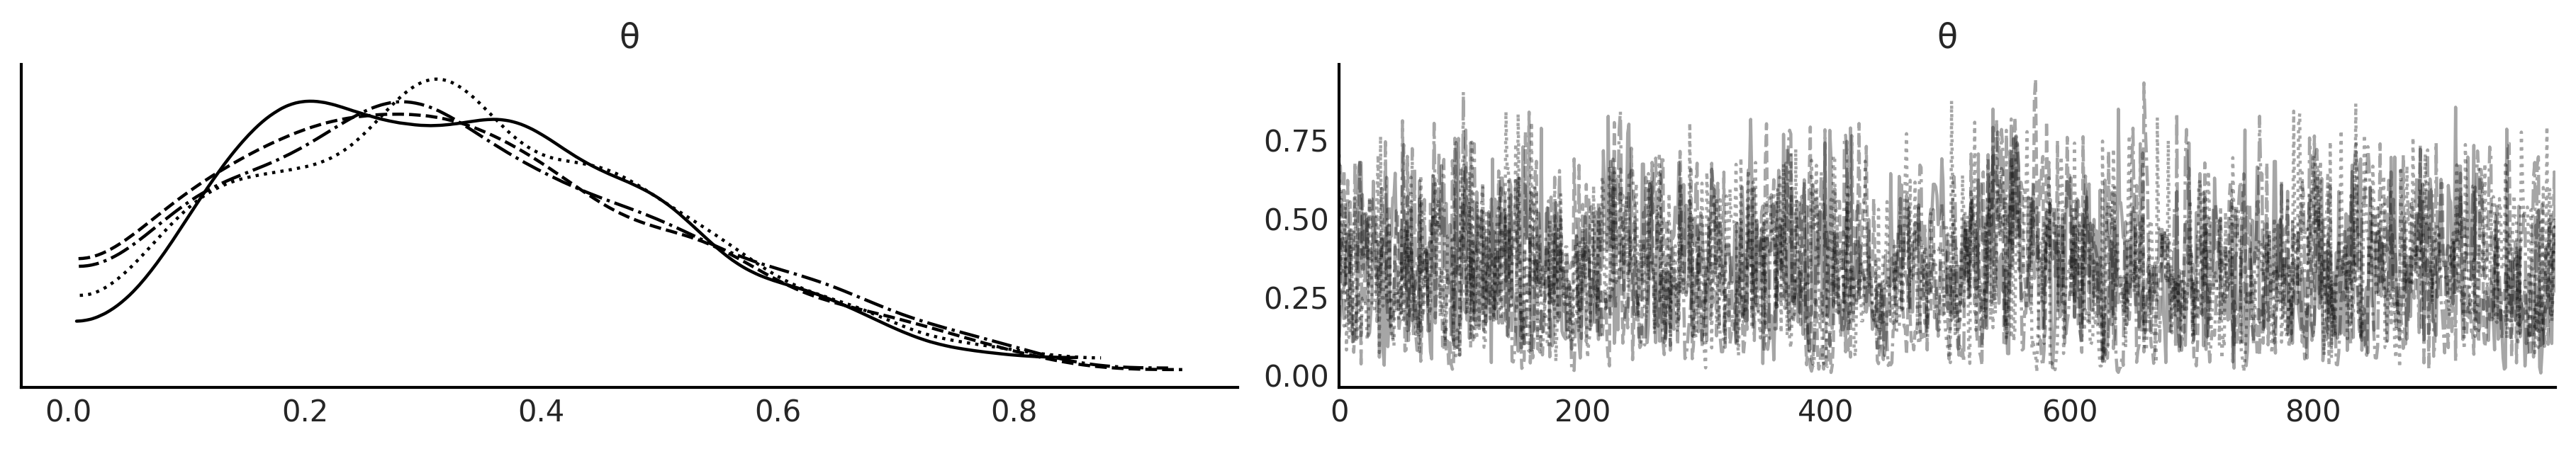

In [5]:
az.plot_trace(idata)
plt.savefig("../fig/idata_trace.png")

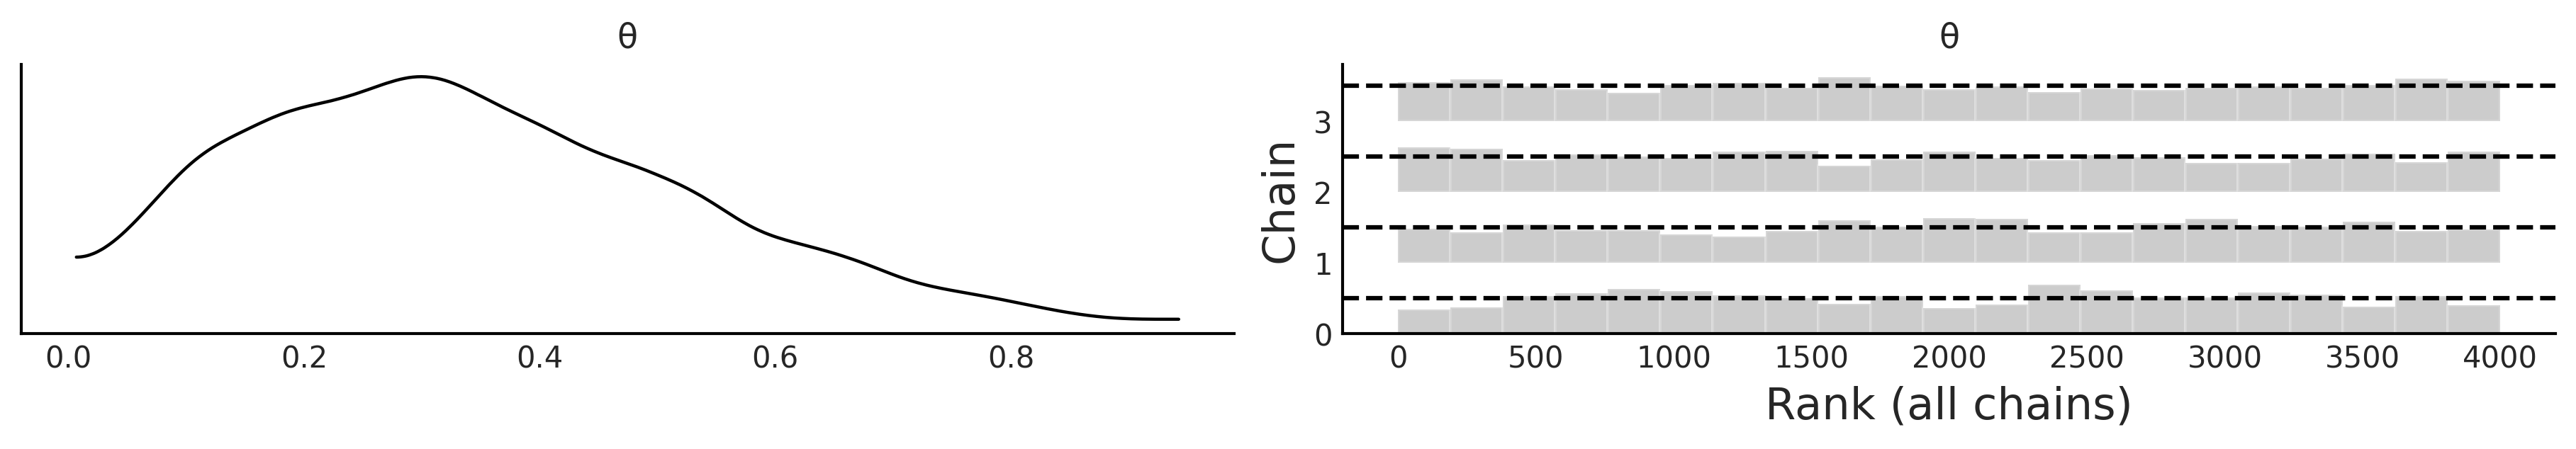

In [6]:
az.plot_trace(idata, kind="rank_bars", combined=True, rank_kwargs={"colors": "k"});
plt.savefig("../fig/idata_rank.png")

In [7]:
az.summary(idata, kind="stats").round(2)

mean    sd  hdi_3%  hdi_97%
θ  0.34  0.18    0.03     0.66

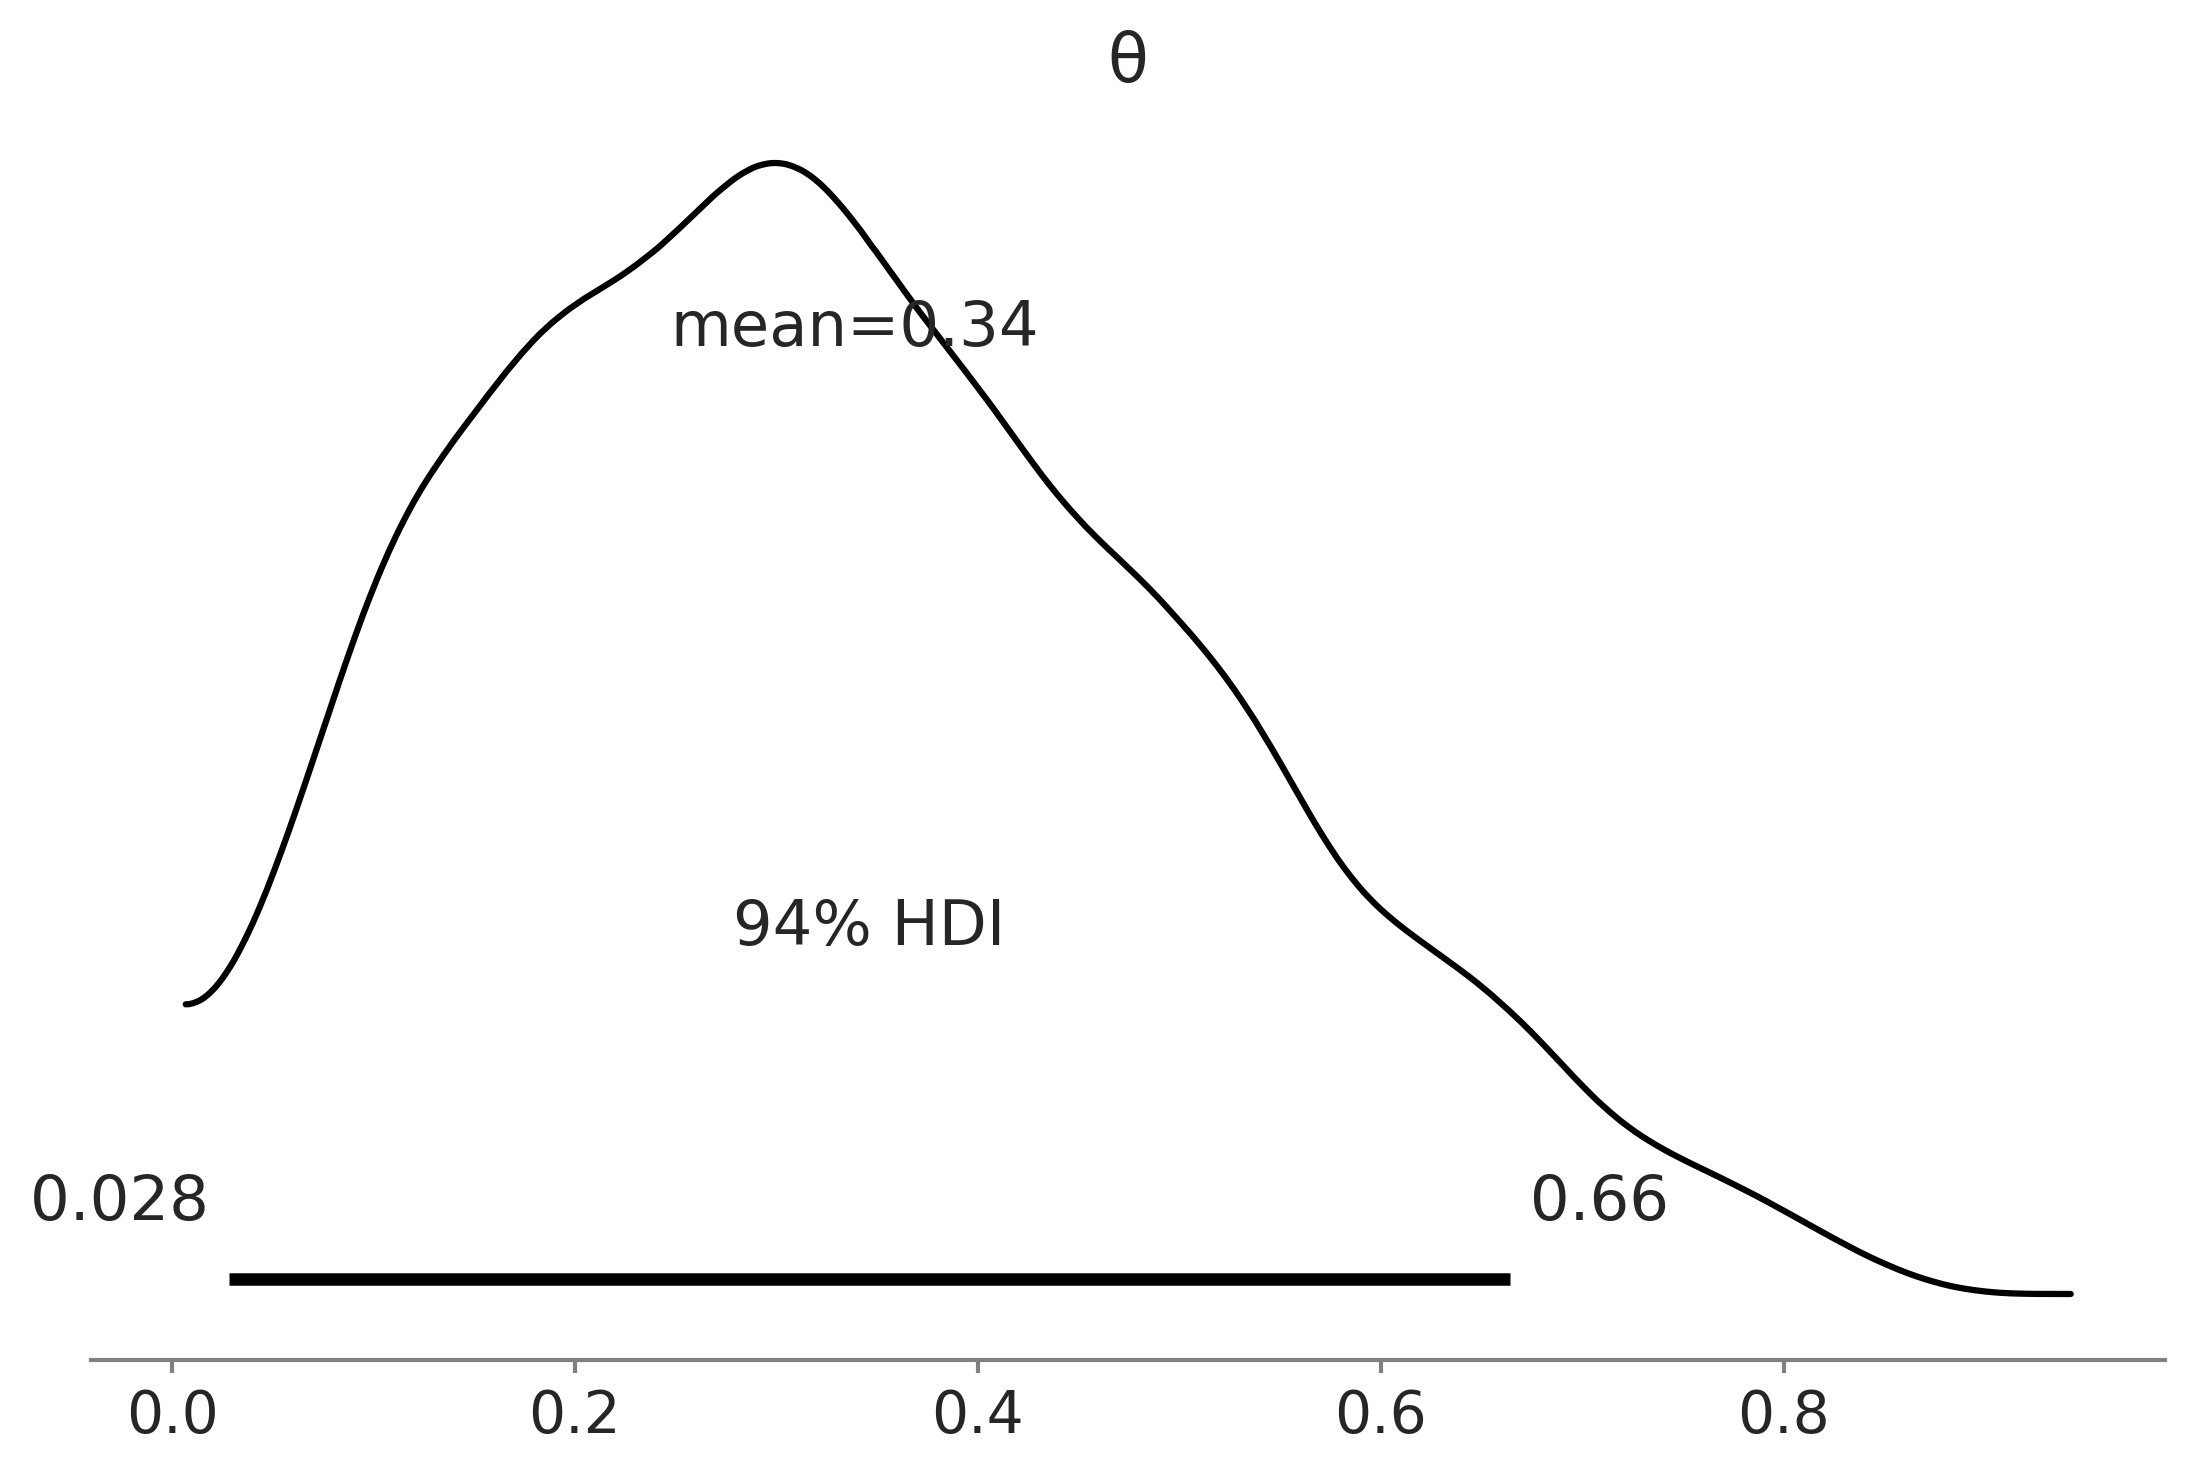

In [8]:
az.plot_posterior(idata)
plt.savefig("../fig/idata_posterior.png")

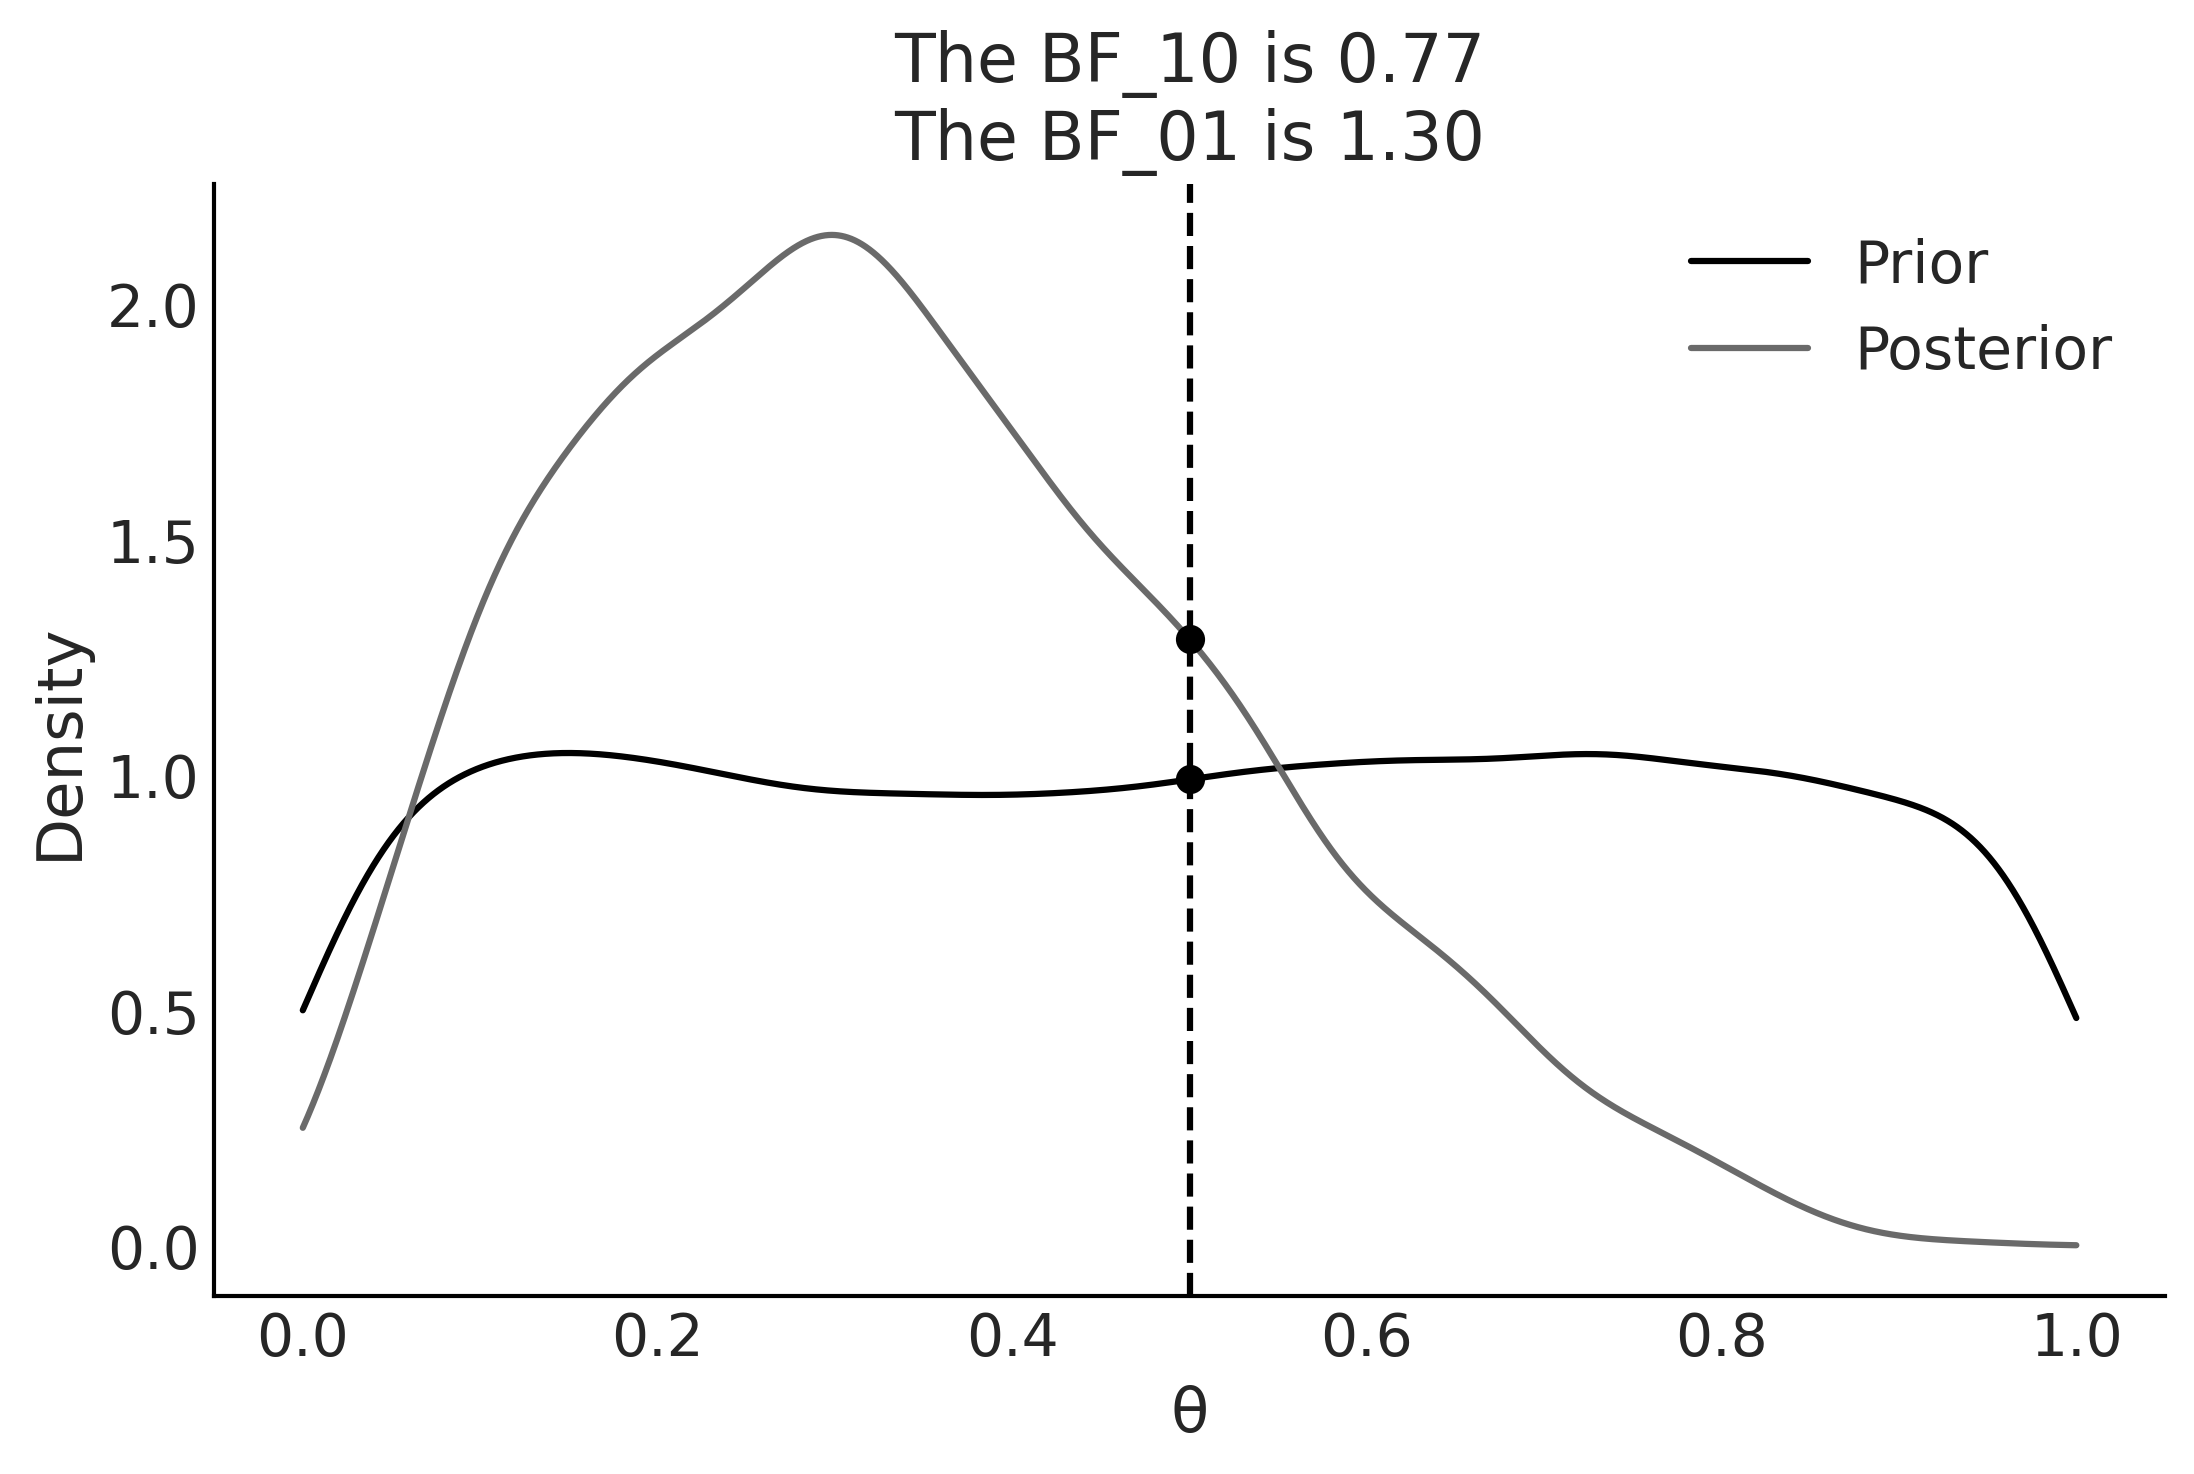

In [9]:
az.plot_bf(idata, var_name="θ", prior=np.random.uniform(0, 1, 10000), ref_val=0.5)
plt.savefig("../fig/idata_bf.png")

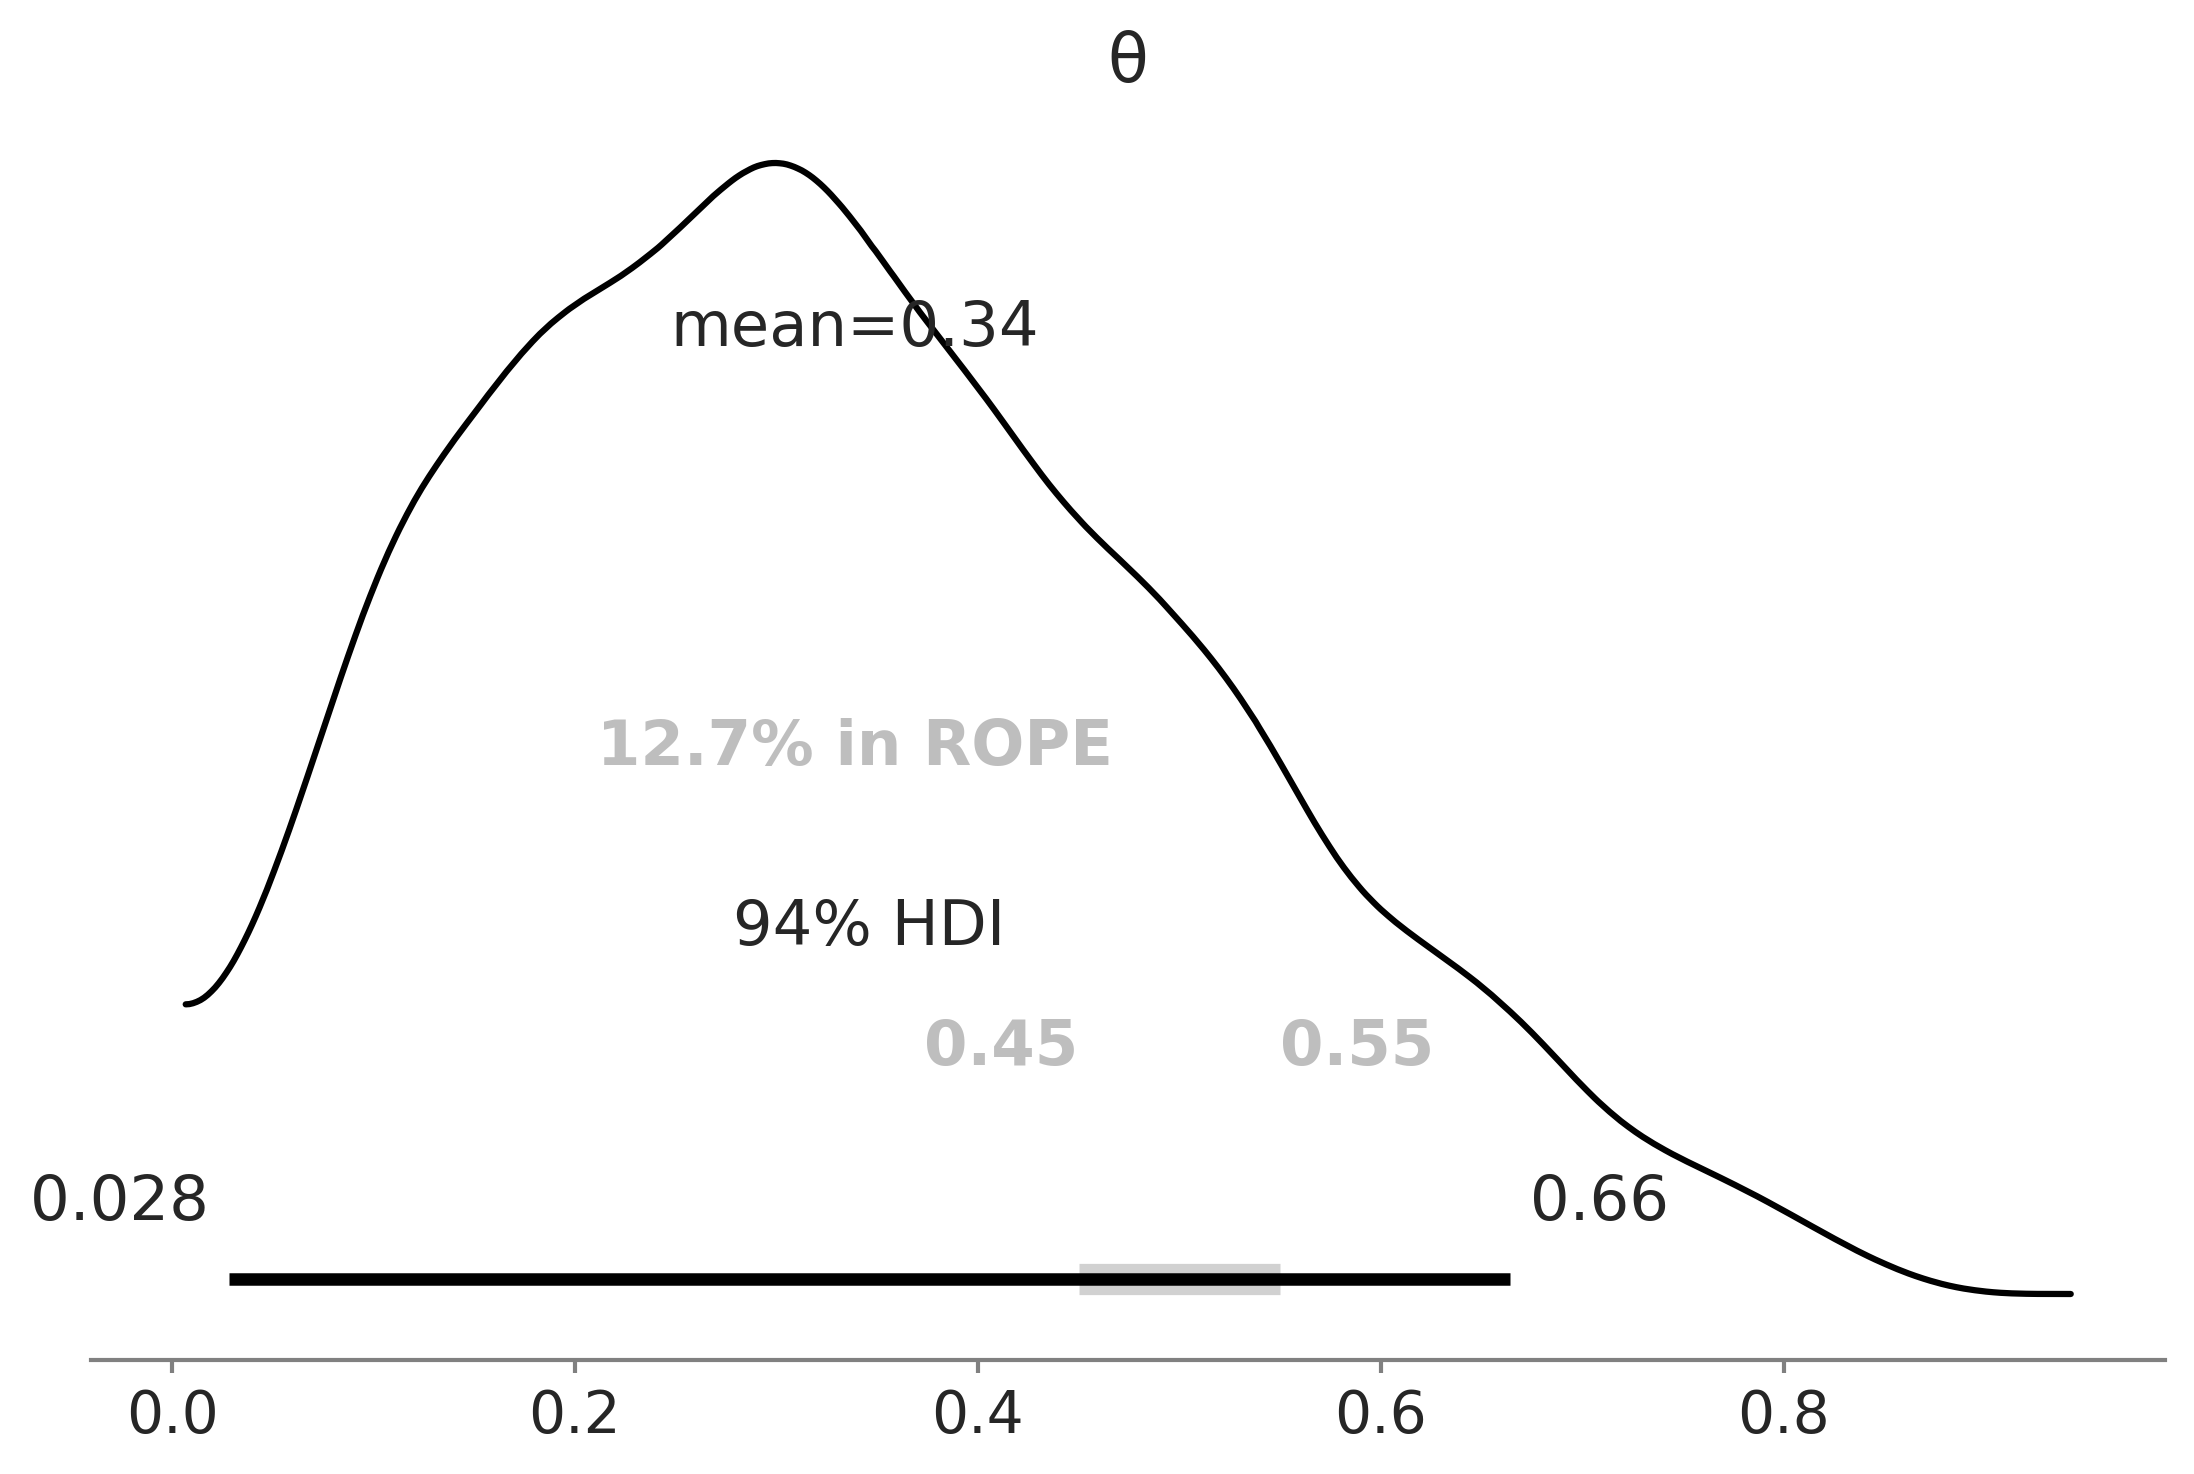

In [10]:
az.plot_posterior(idata, rope=[0.45, .55])
plt.savefig("../fig/idata_posterior_rope.png")


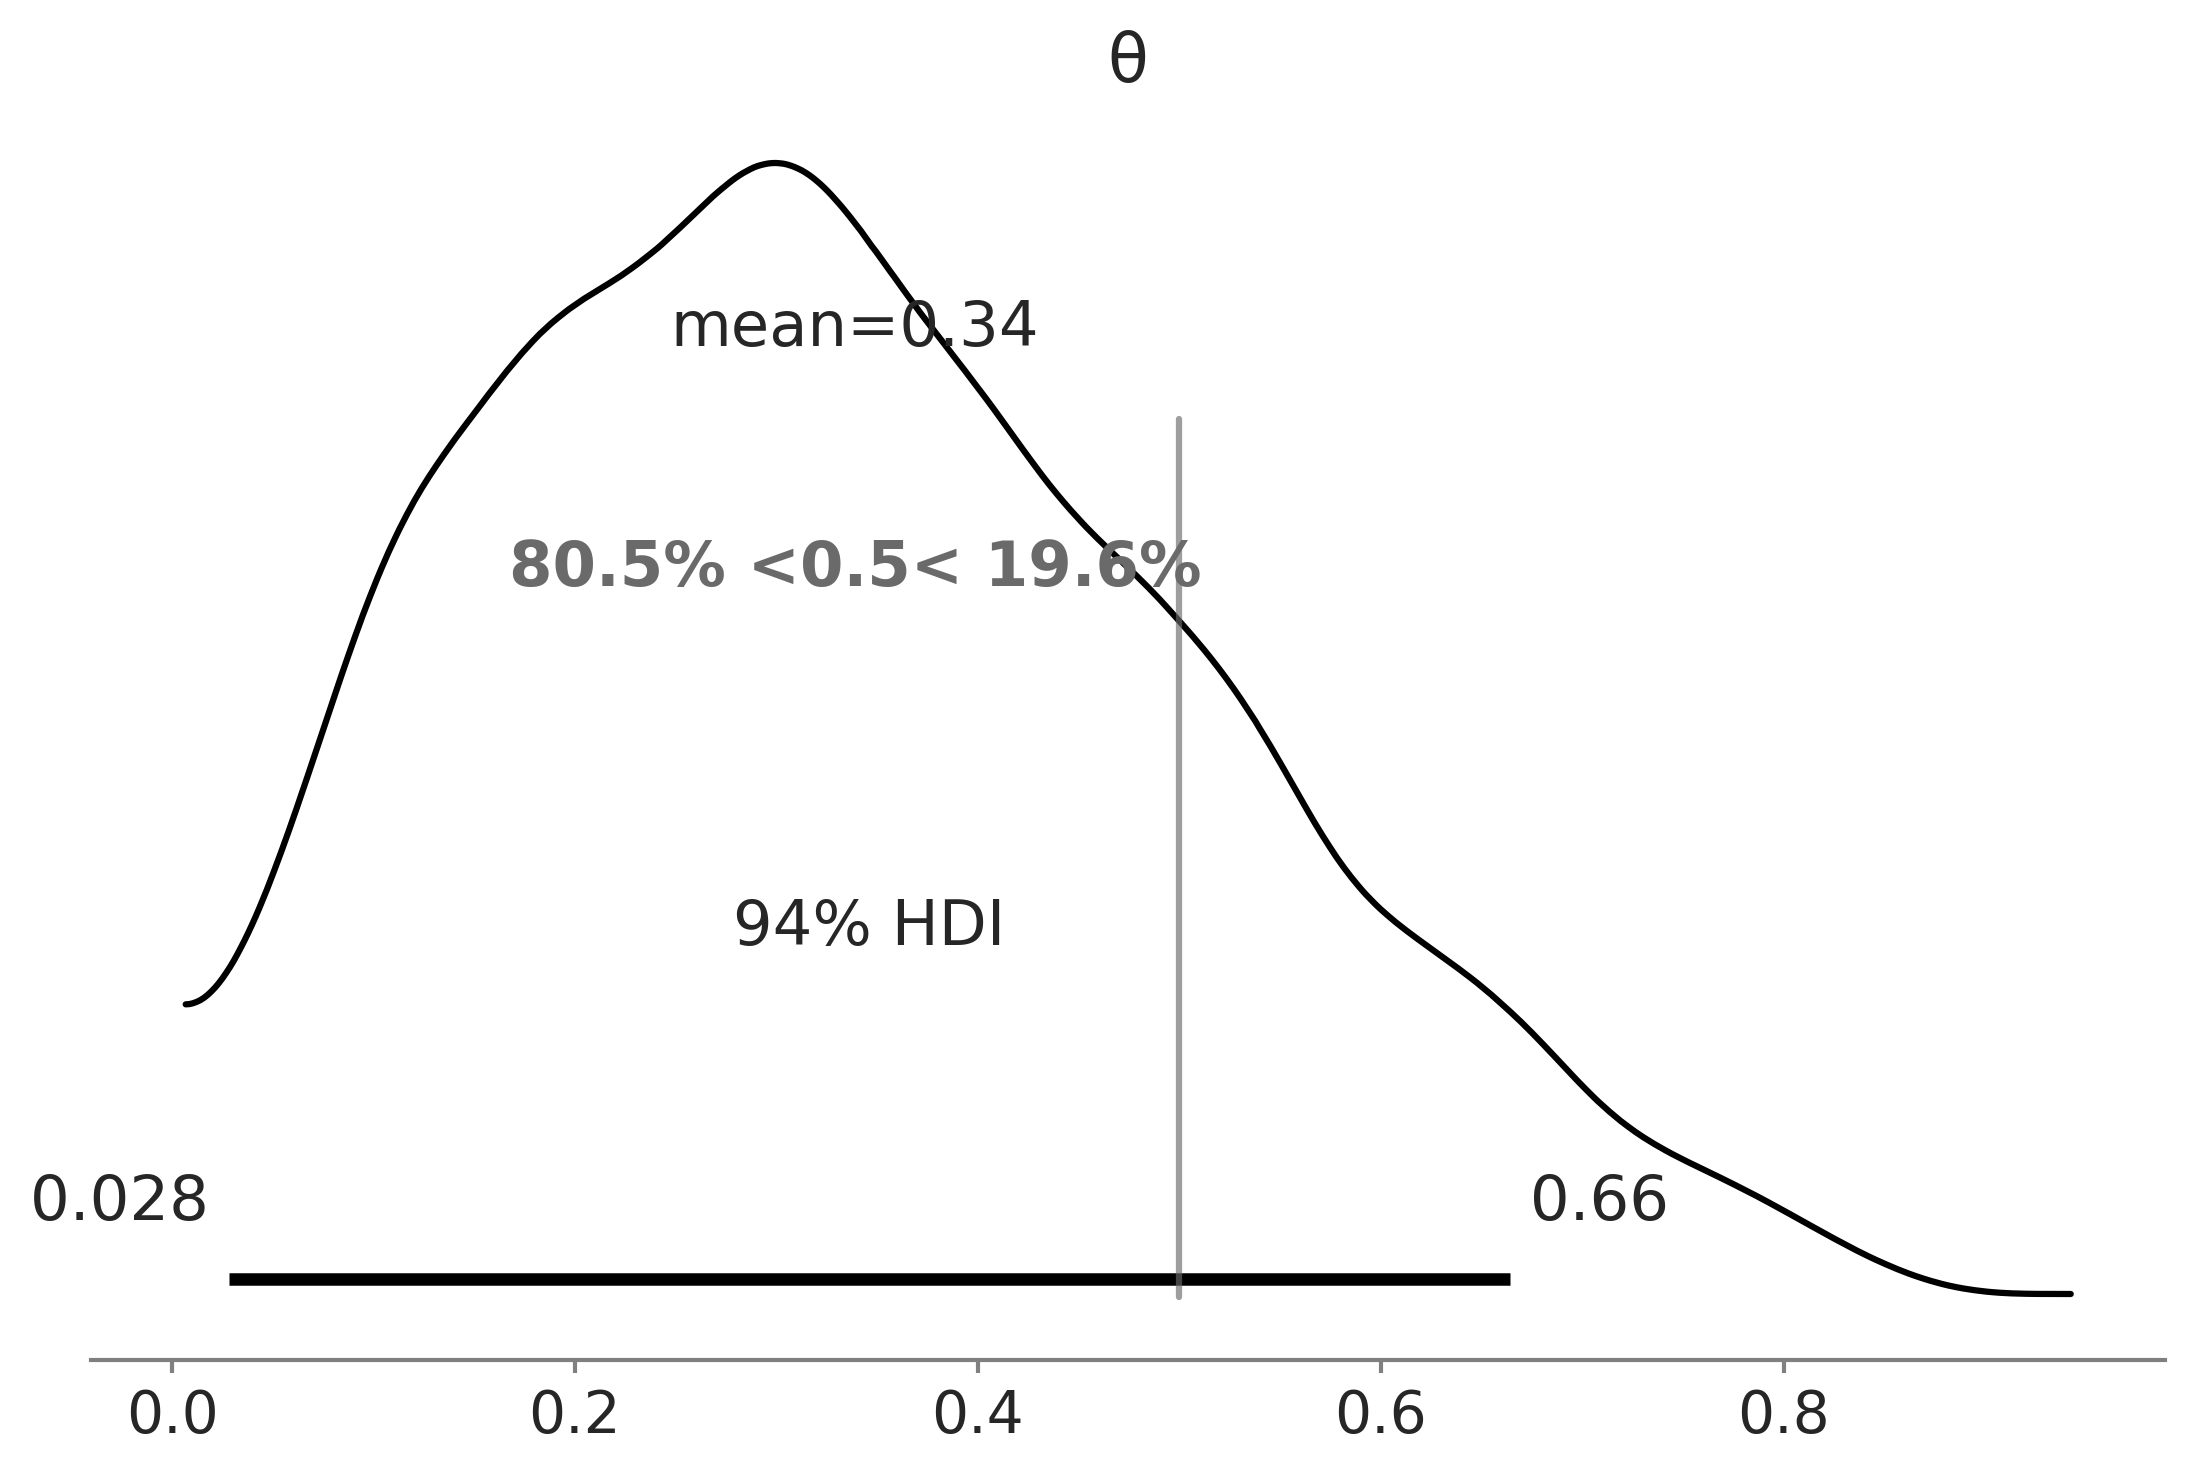

In [11]:
az.plot_posterior(idata, ref_val=0.5)
plt.savefig("../fig/idata_posterior_ref.png")

In [12]:
grid = np.linspace(0, 1, 200)
θ_pos = idata.posterior['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]
np.argmin(lossf_a)

64

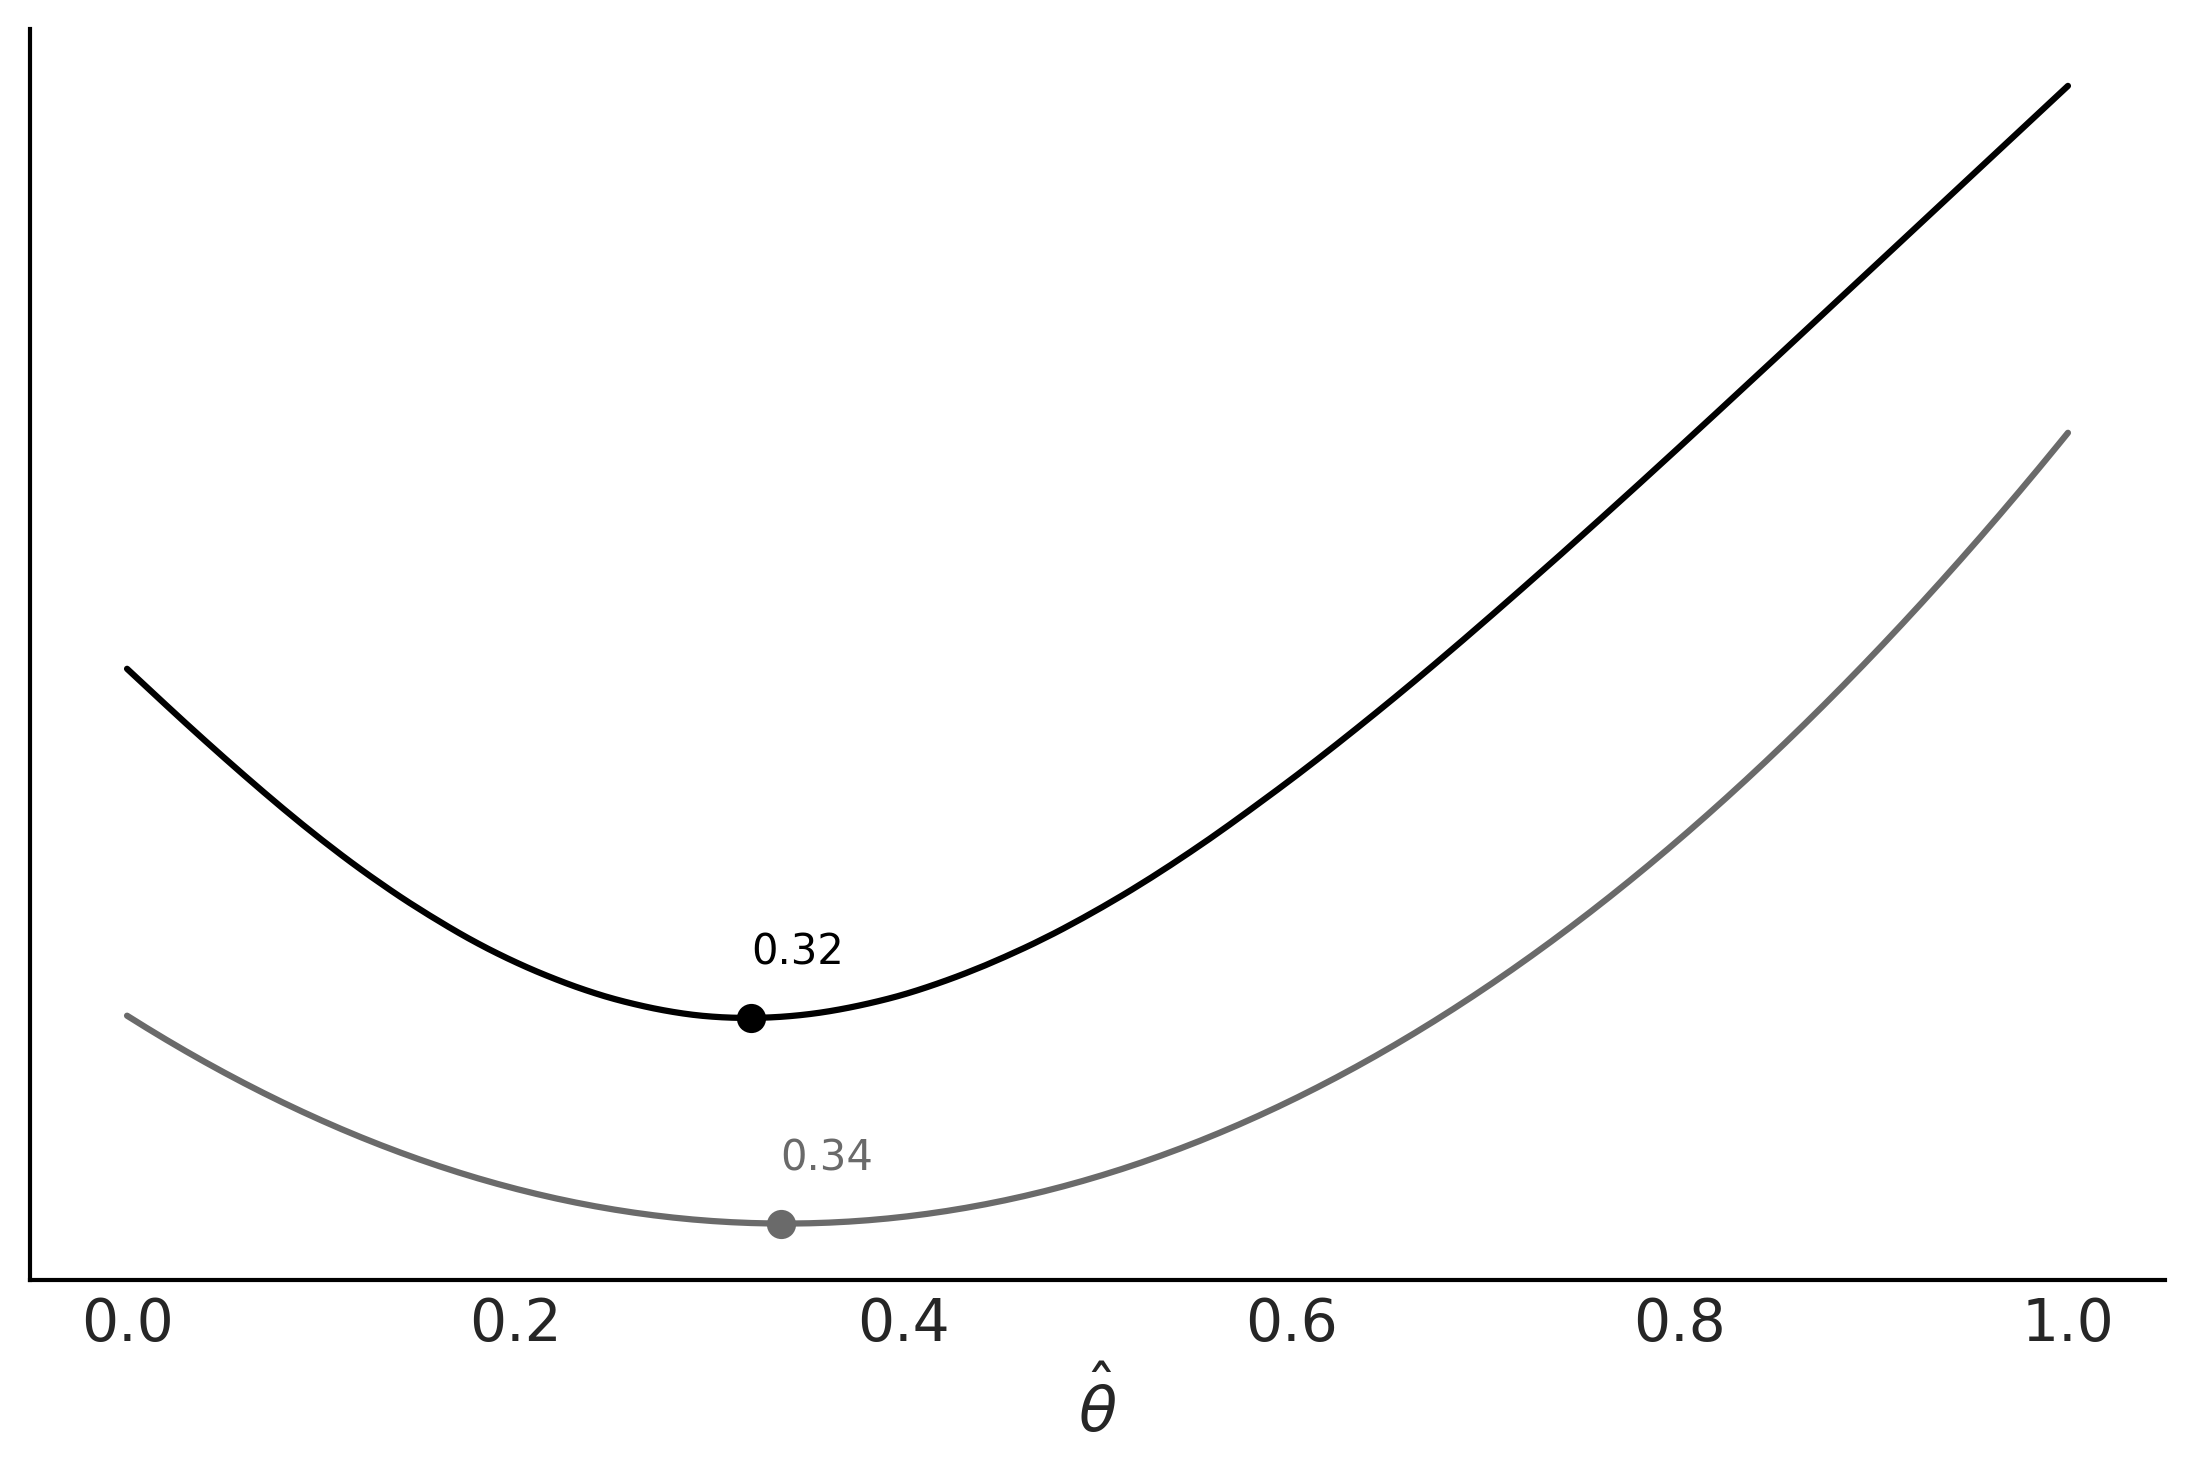

In [13]:
grid = np.linspace(0, 1, 200)
θ_pos = idata.posterior['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]
for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
    (grid[mini], lossf[mini] + 0.03), color=c)

    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')

plt.savefig("../fig/idata_loss.png")

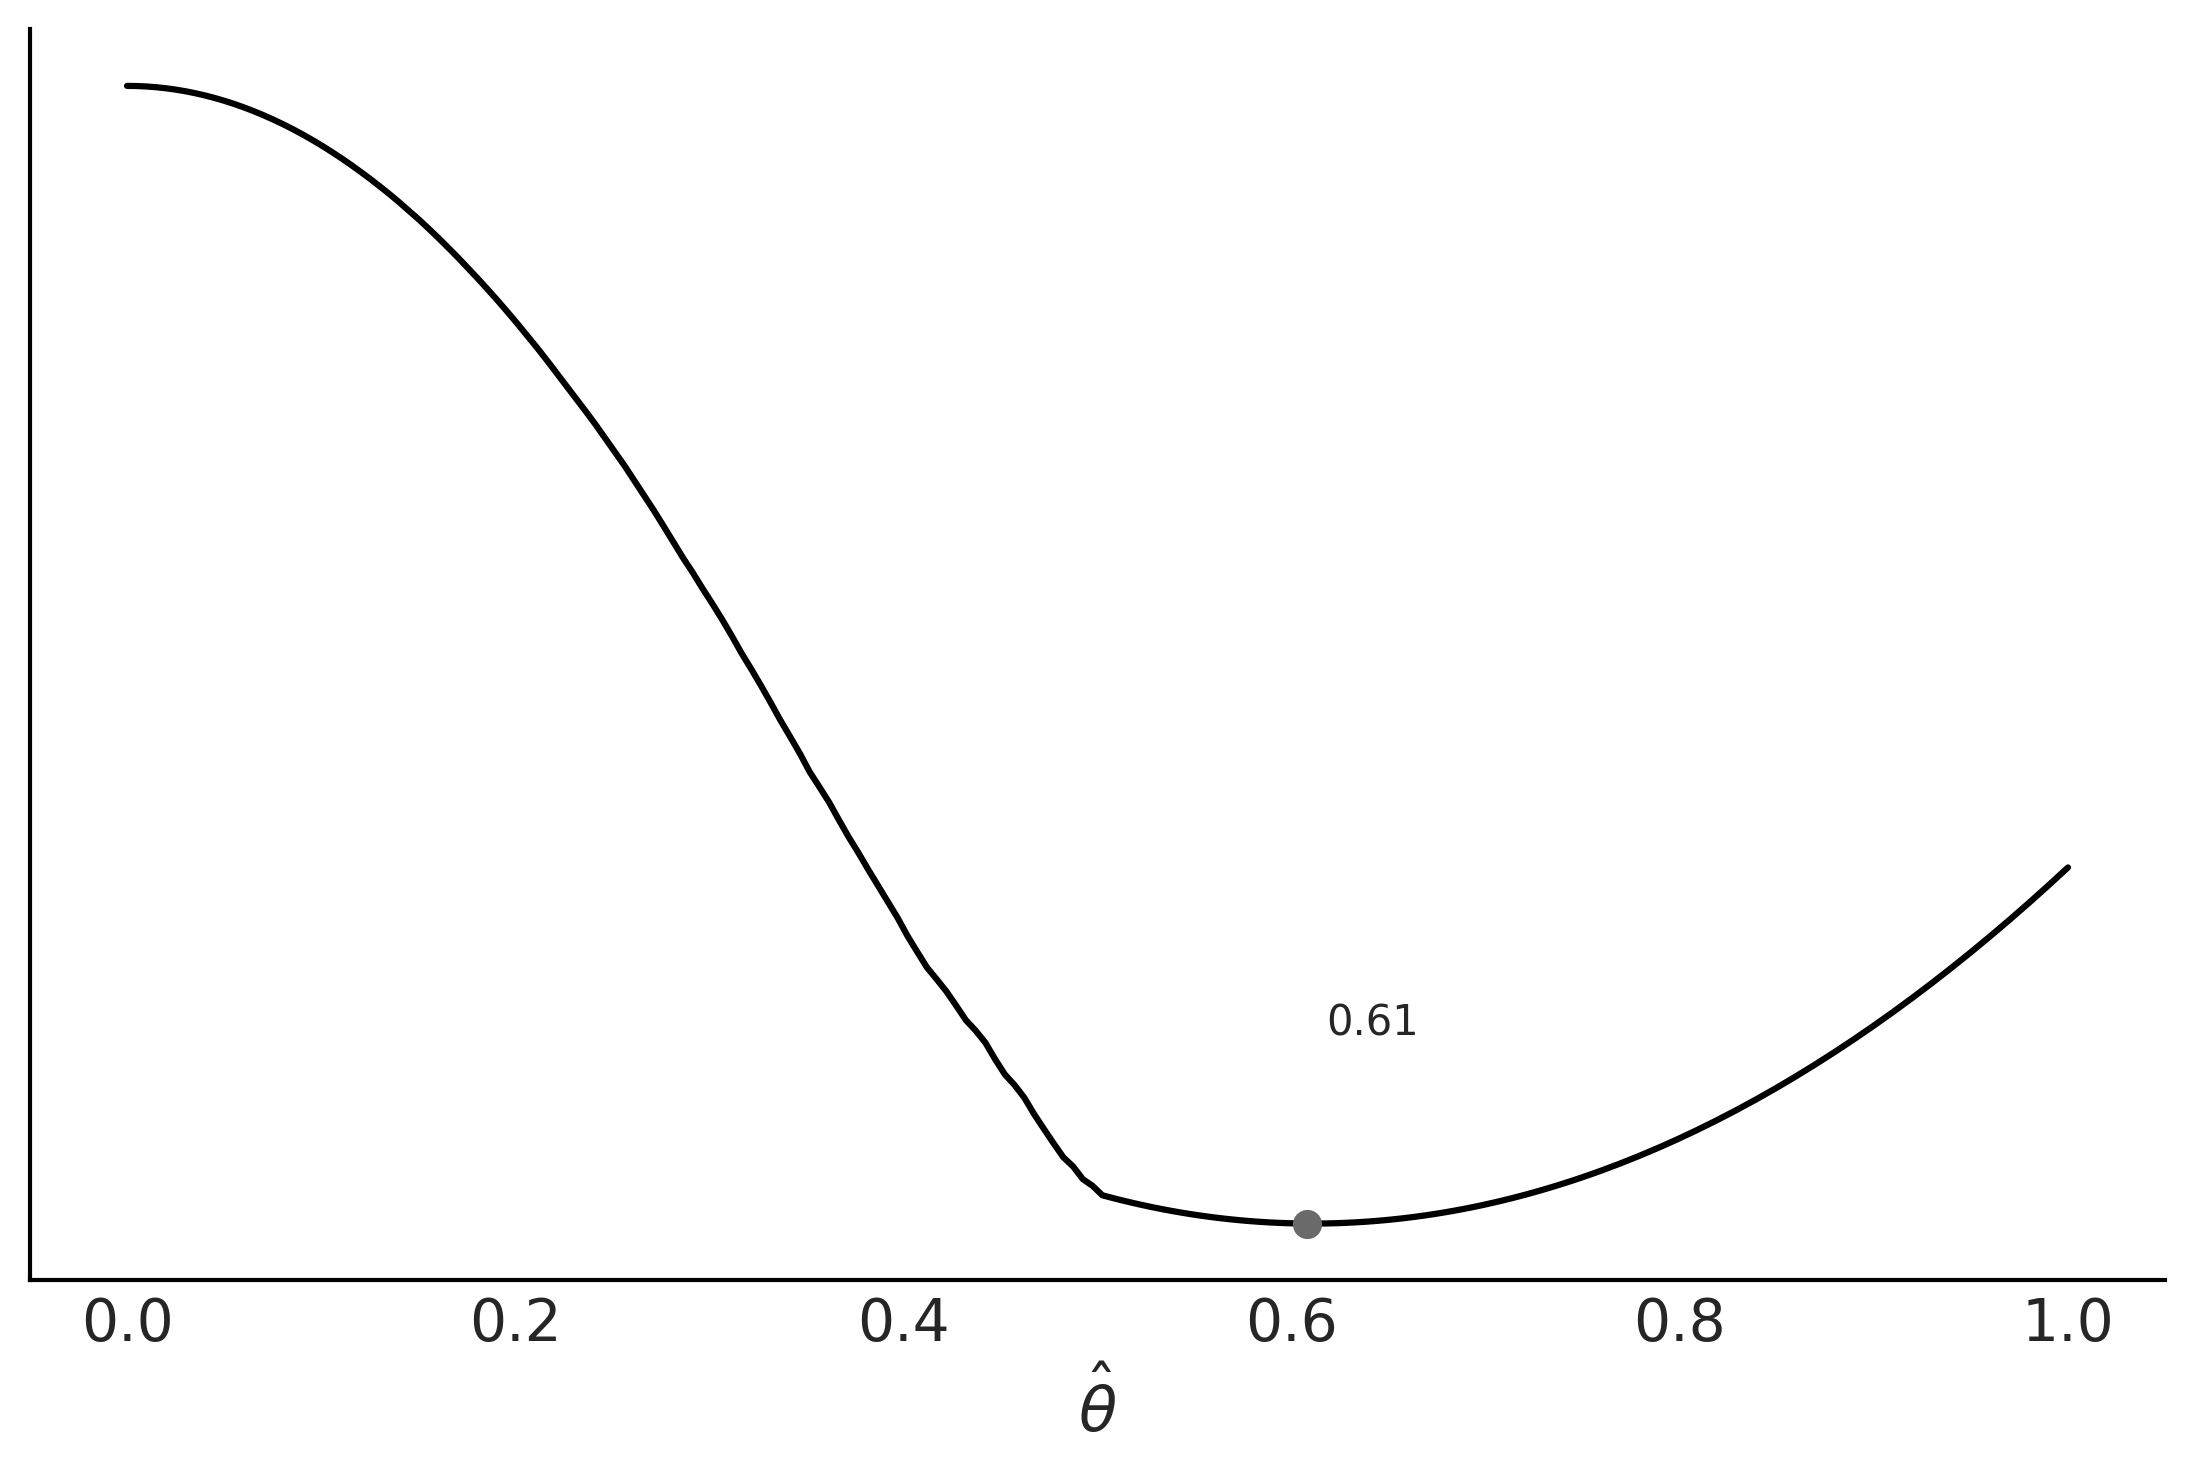

In [14]:
lossf = []
for i in grid:
    if i < 0.5:
        f = 1/np.median(θ_pos / np.abs(i**2 - θ_pos))
    else:
        f = np.mean((i - θ_pos)**2 + np.exp(-i)) - 0.25
    lossf.append(f)
mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
(grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')
plt.savefig("../fig/idata_loss2.png")

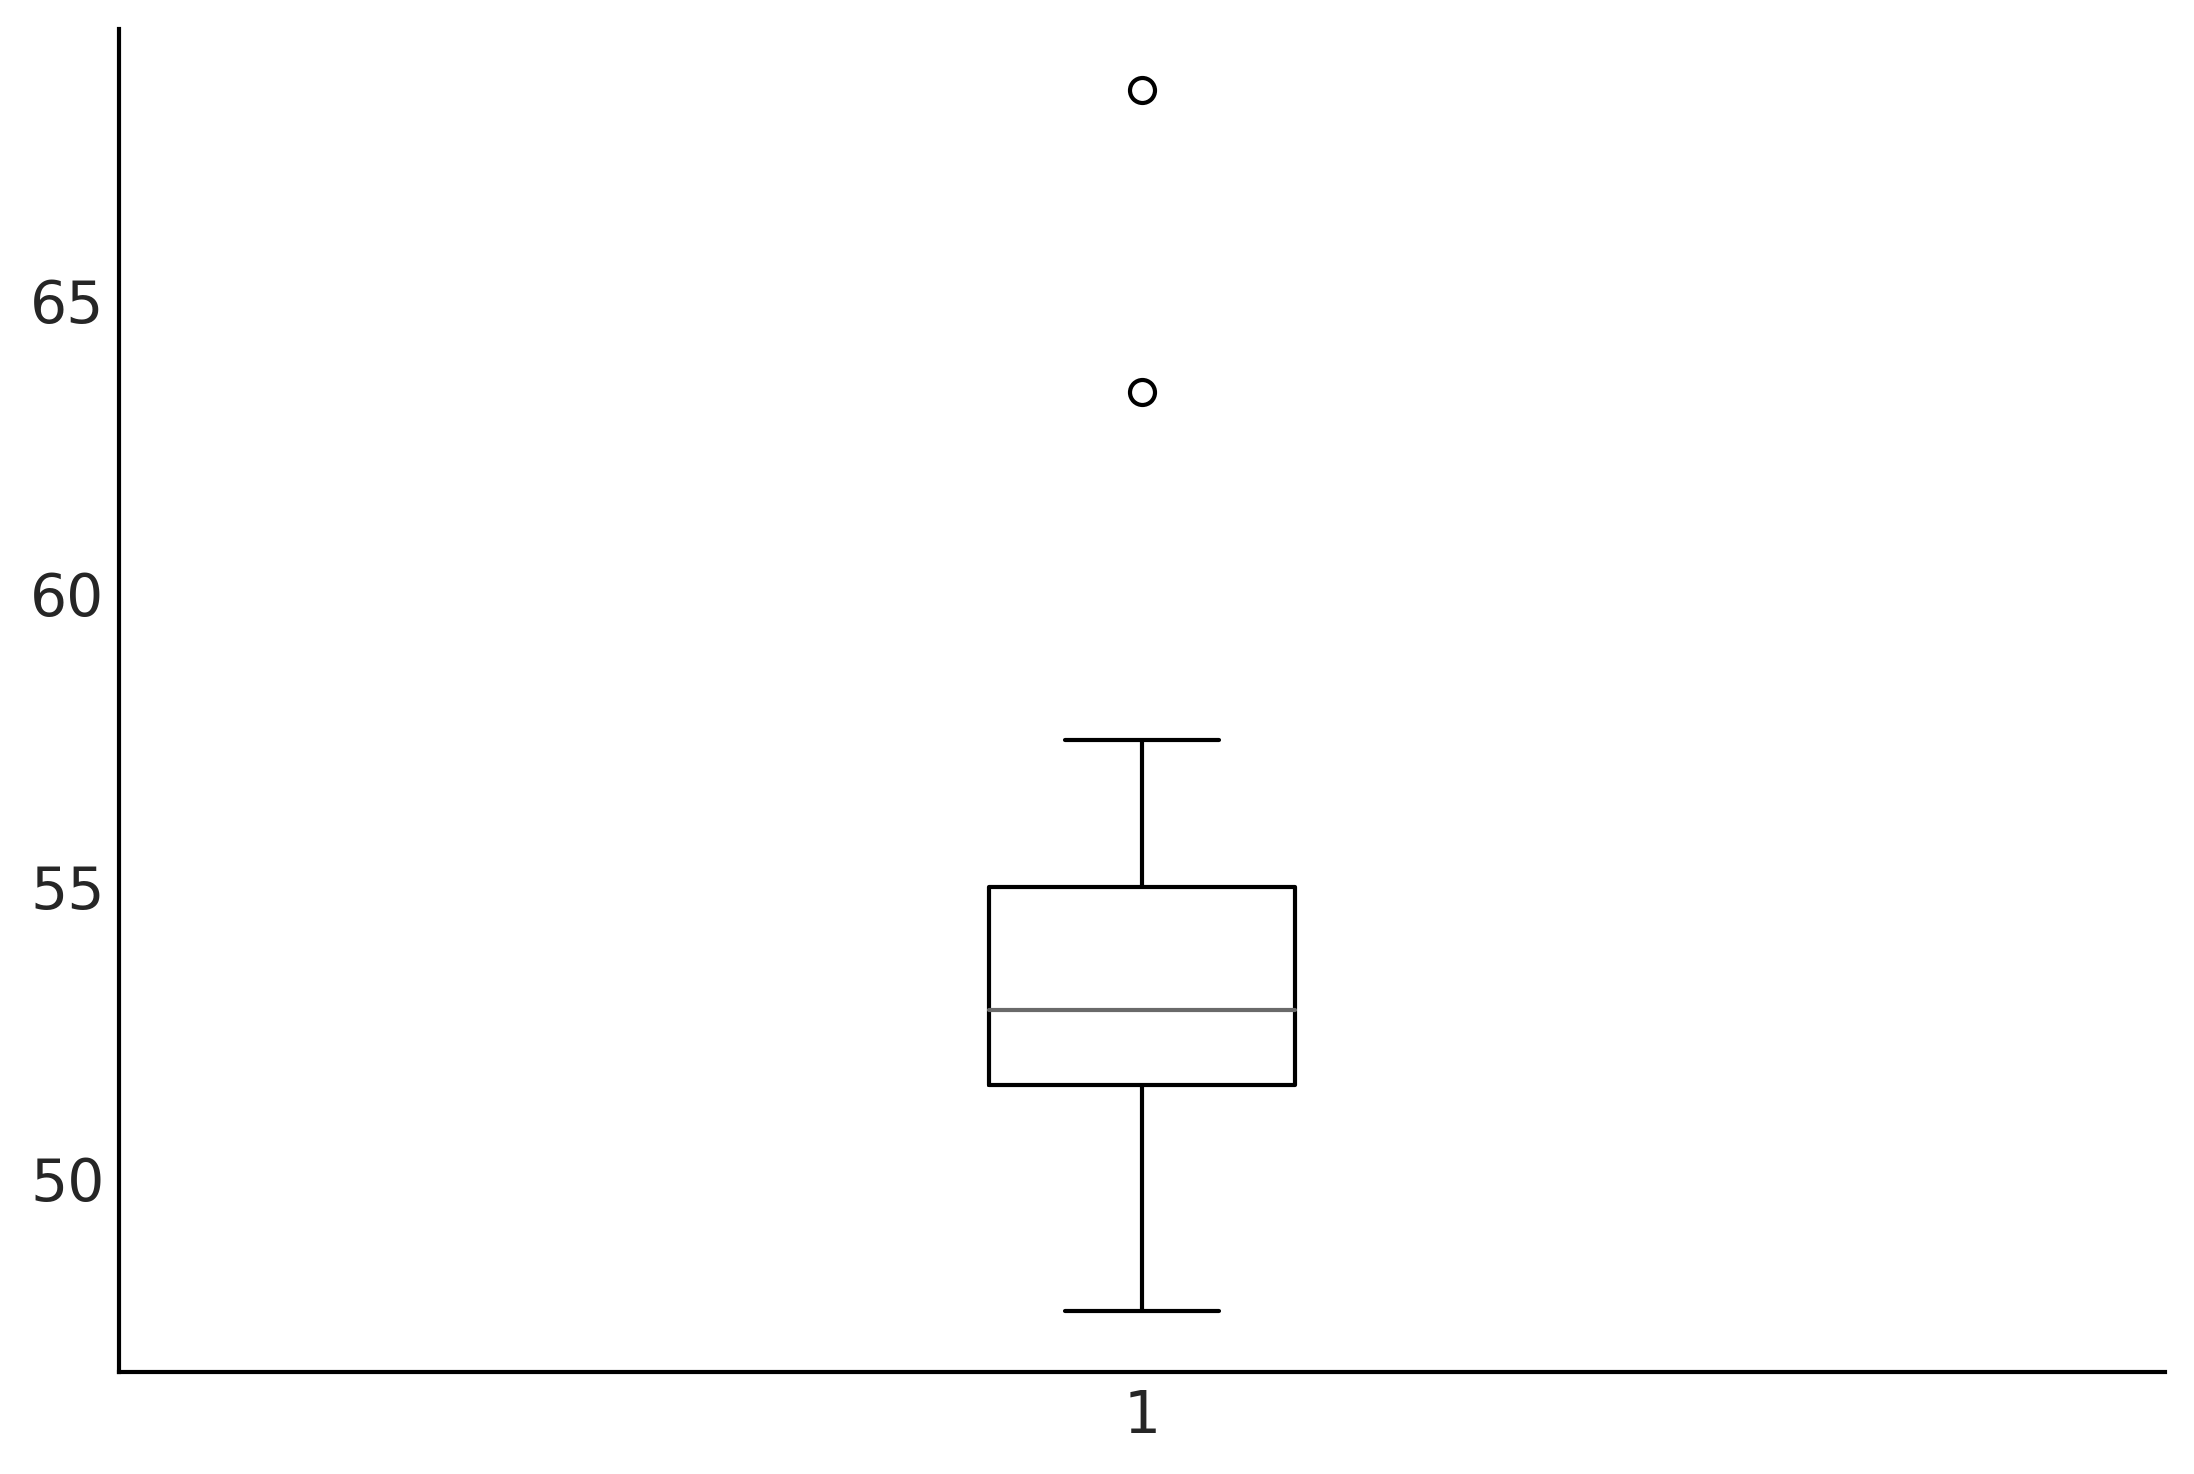

In [15]:
data = np.loadtxt('../data/chemical_shifts.csv')
plt.boxplot(data)
plt.savefig("../fig/boxplot.png")

In [16]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sigma=5)
    Y = pm.Normal('Y', mu=μ, sigma=σ, observed=data)
    idata_g = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


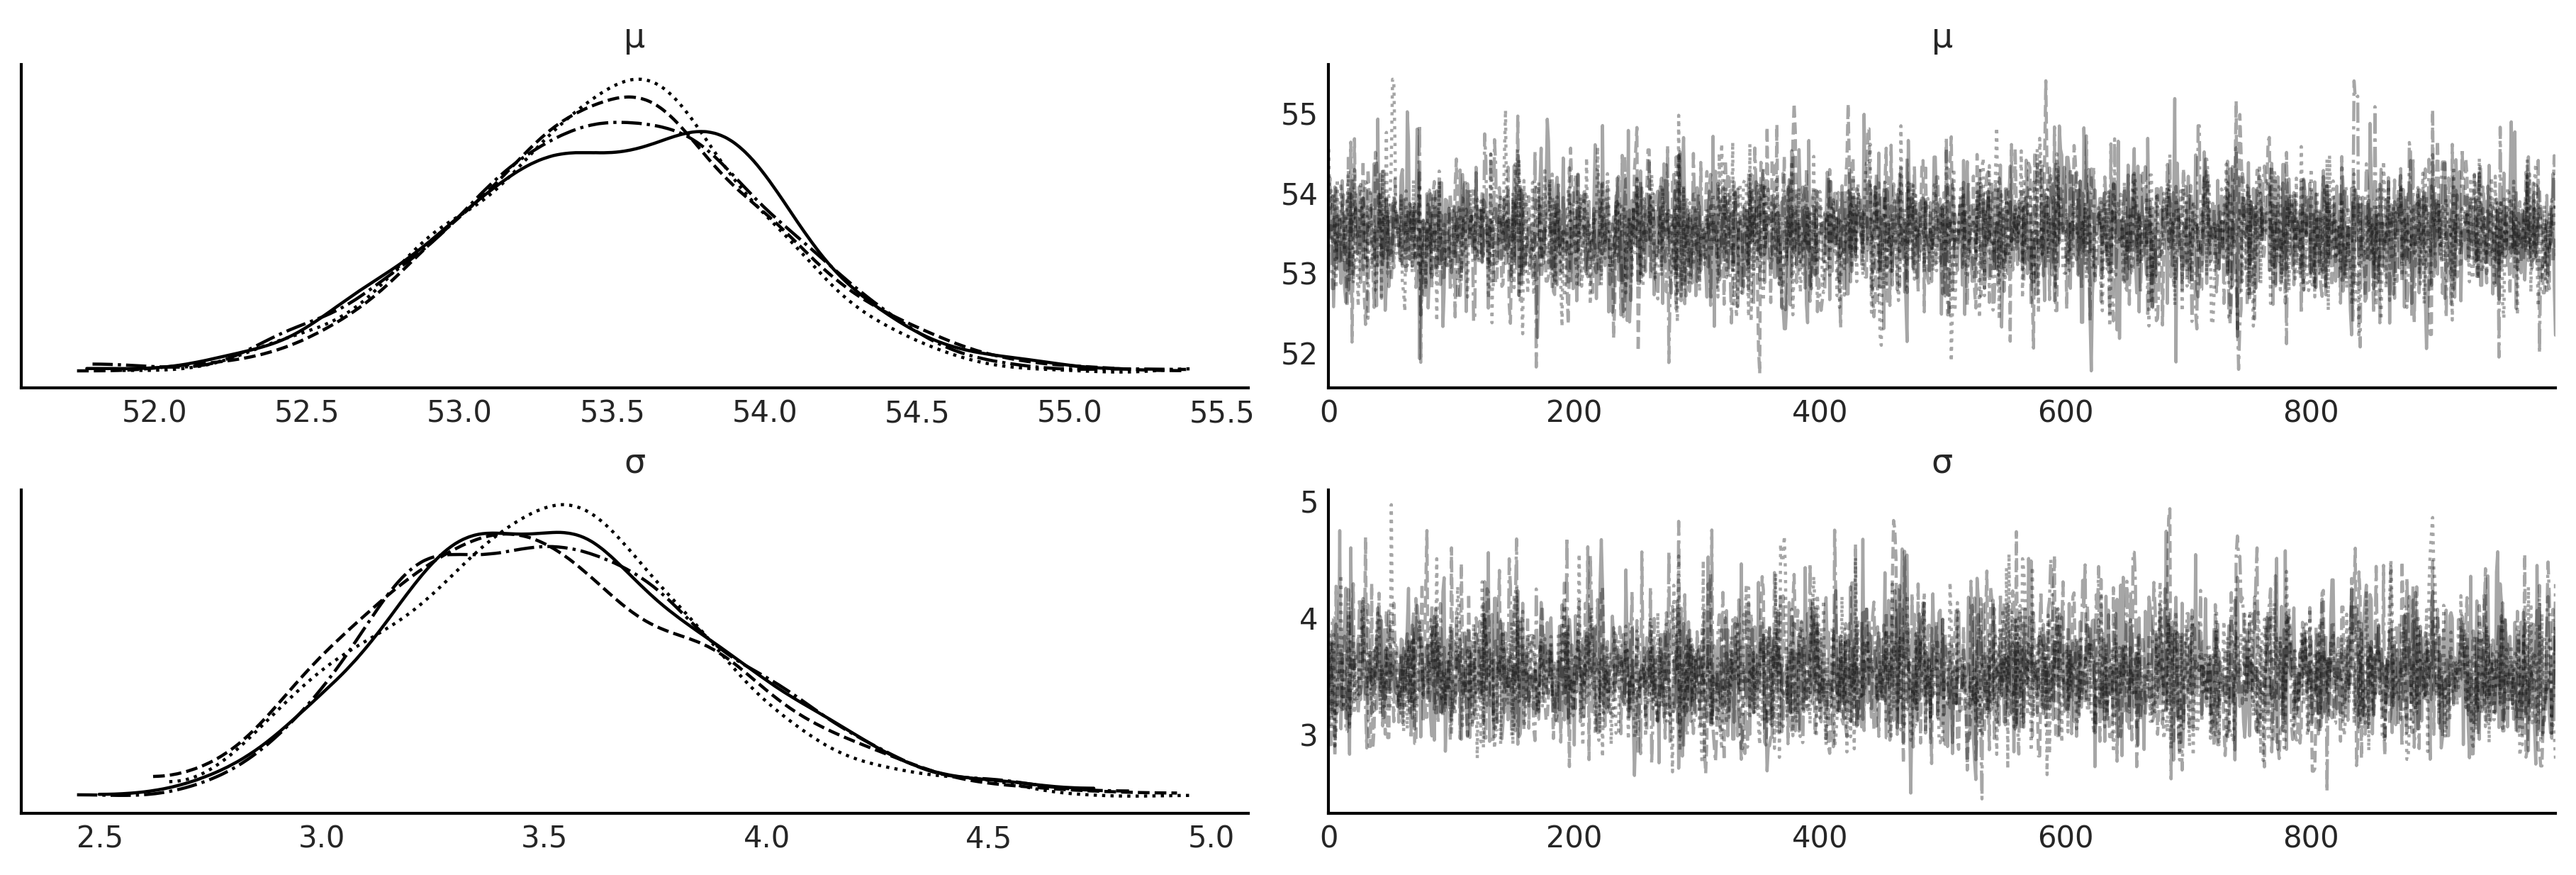

In [17]:
az.plot_trace(idata_g);
plt.savefig("../fig/idata_g.png")

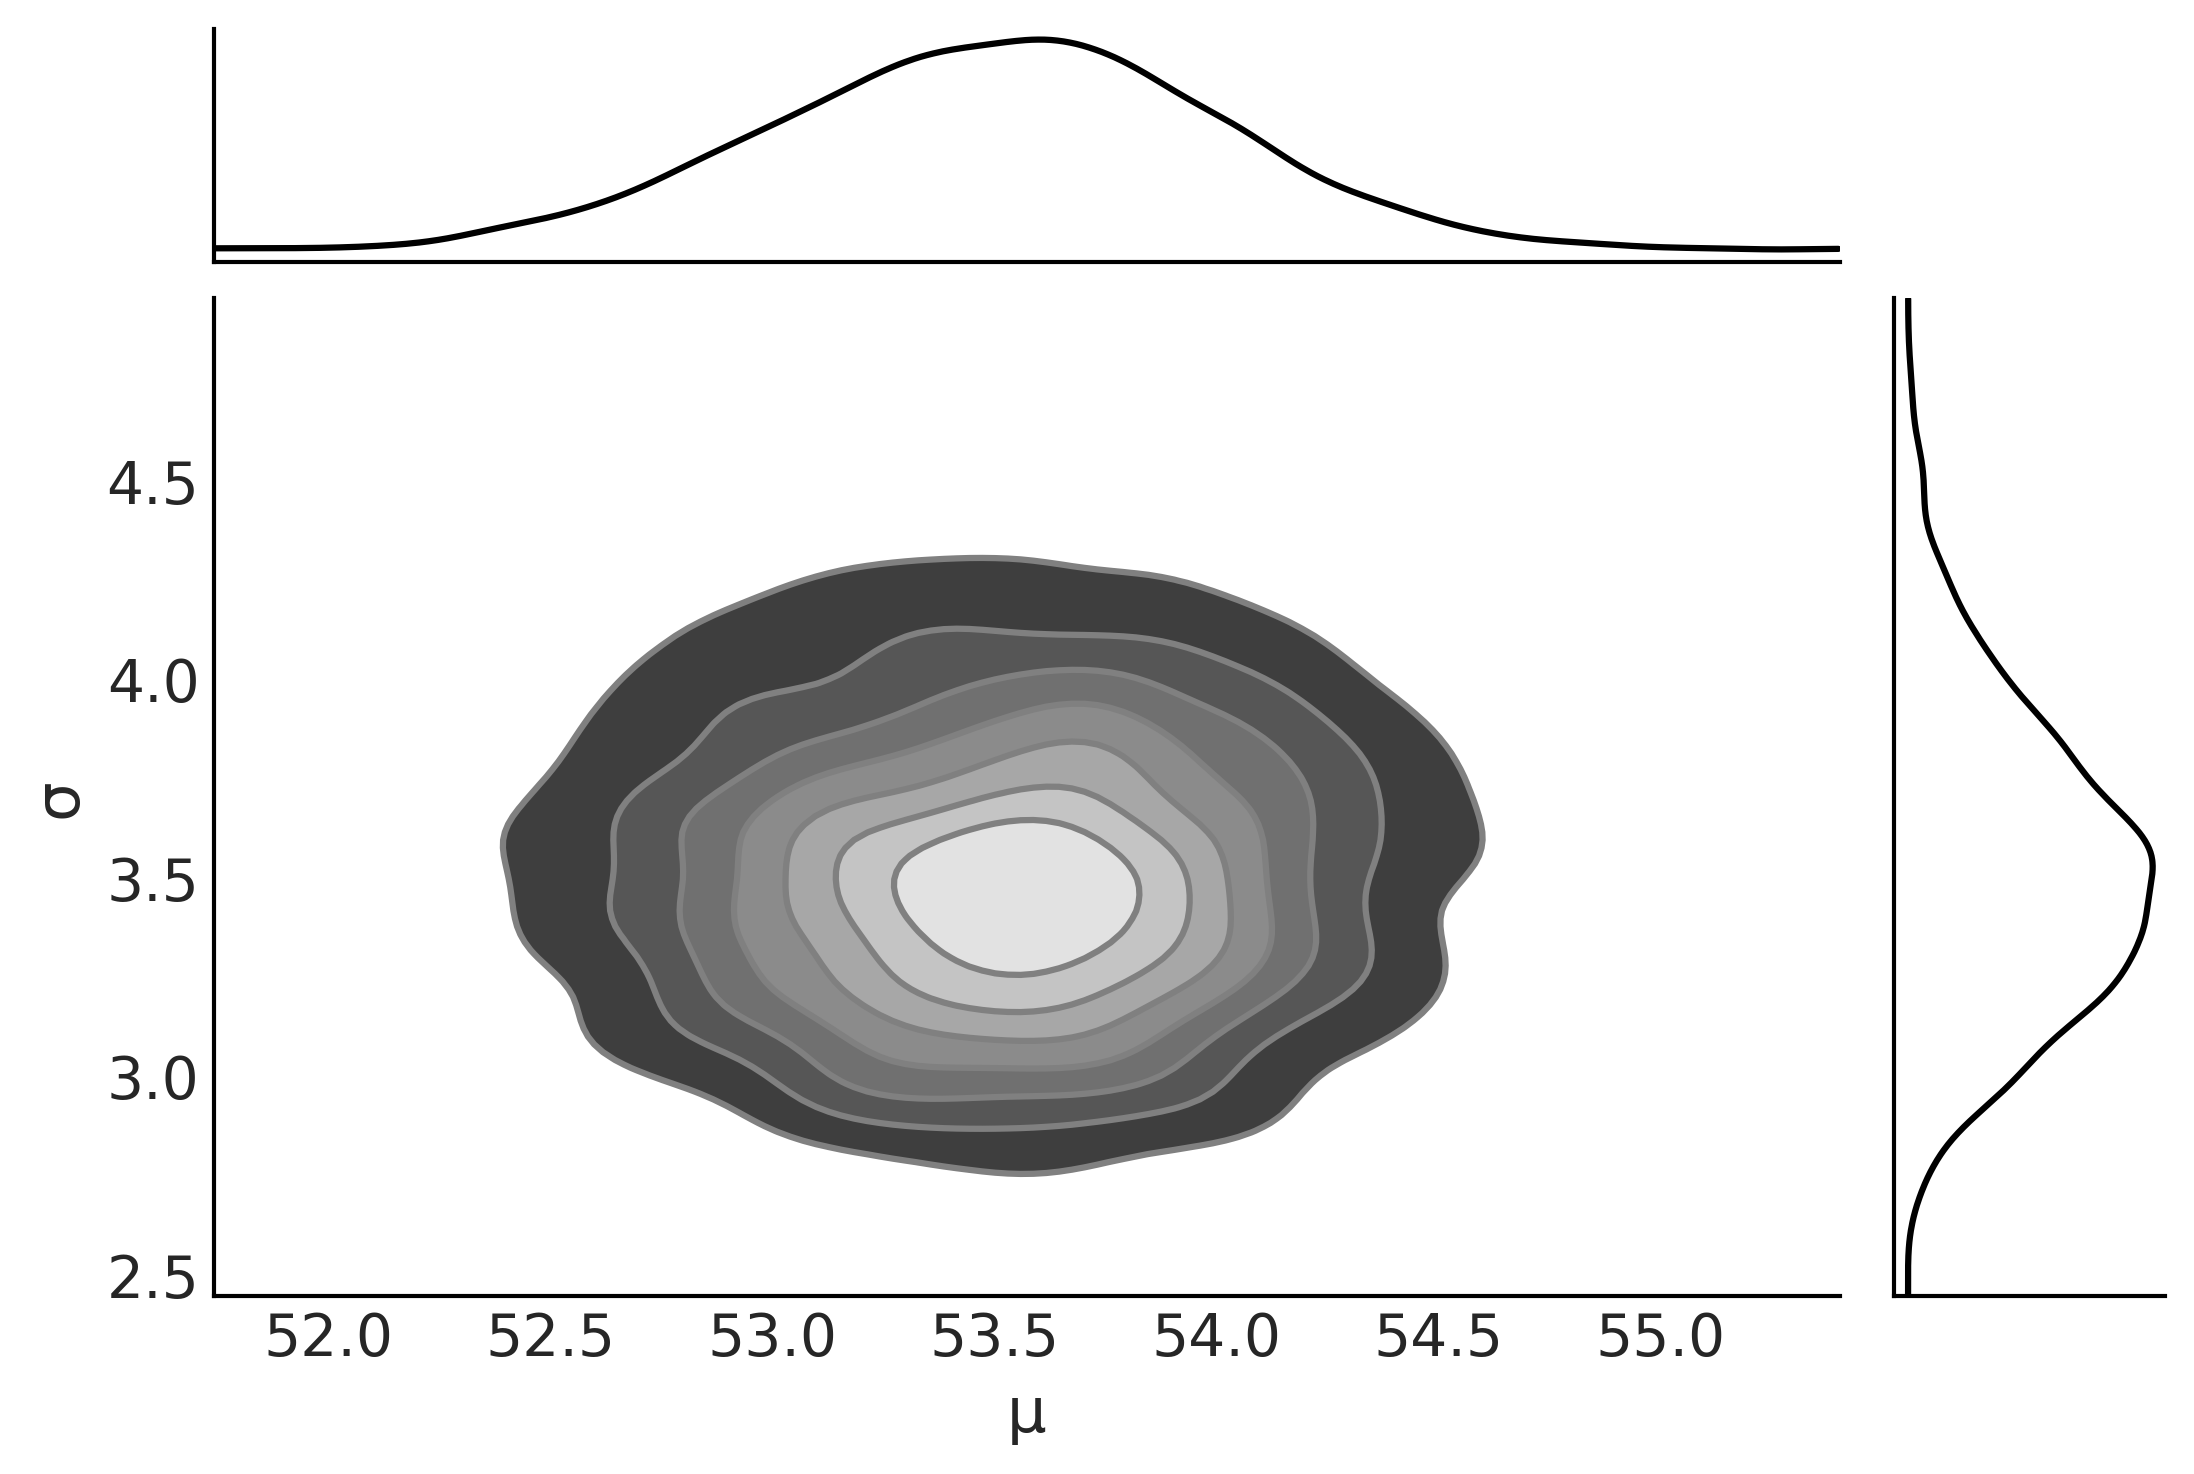

In [18]:
az.plot_pair(idata_g, kind='kde', marginals=True)
plt.savefig("../fig/idata_g_pair.png")

In [20]:
az.summary(idata_g, kind="stats").round(2)

mean    sd  hdi_3%  hdi_97%
μ  53.50  0.52   52.51    54.44
σ   3.52  0.38    2.86     4.25

In [23]:
pm.sample_posterior_predictive(idata_g, model=model_g, extend_inferencedata=True)


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<AxesSubplot:xlabel='Y / Y'>

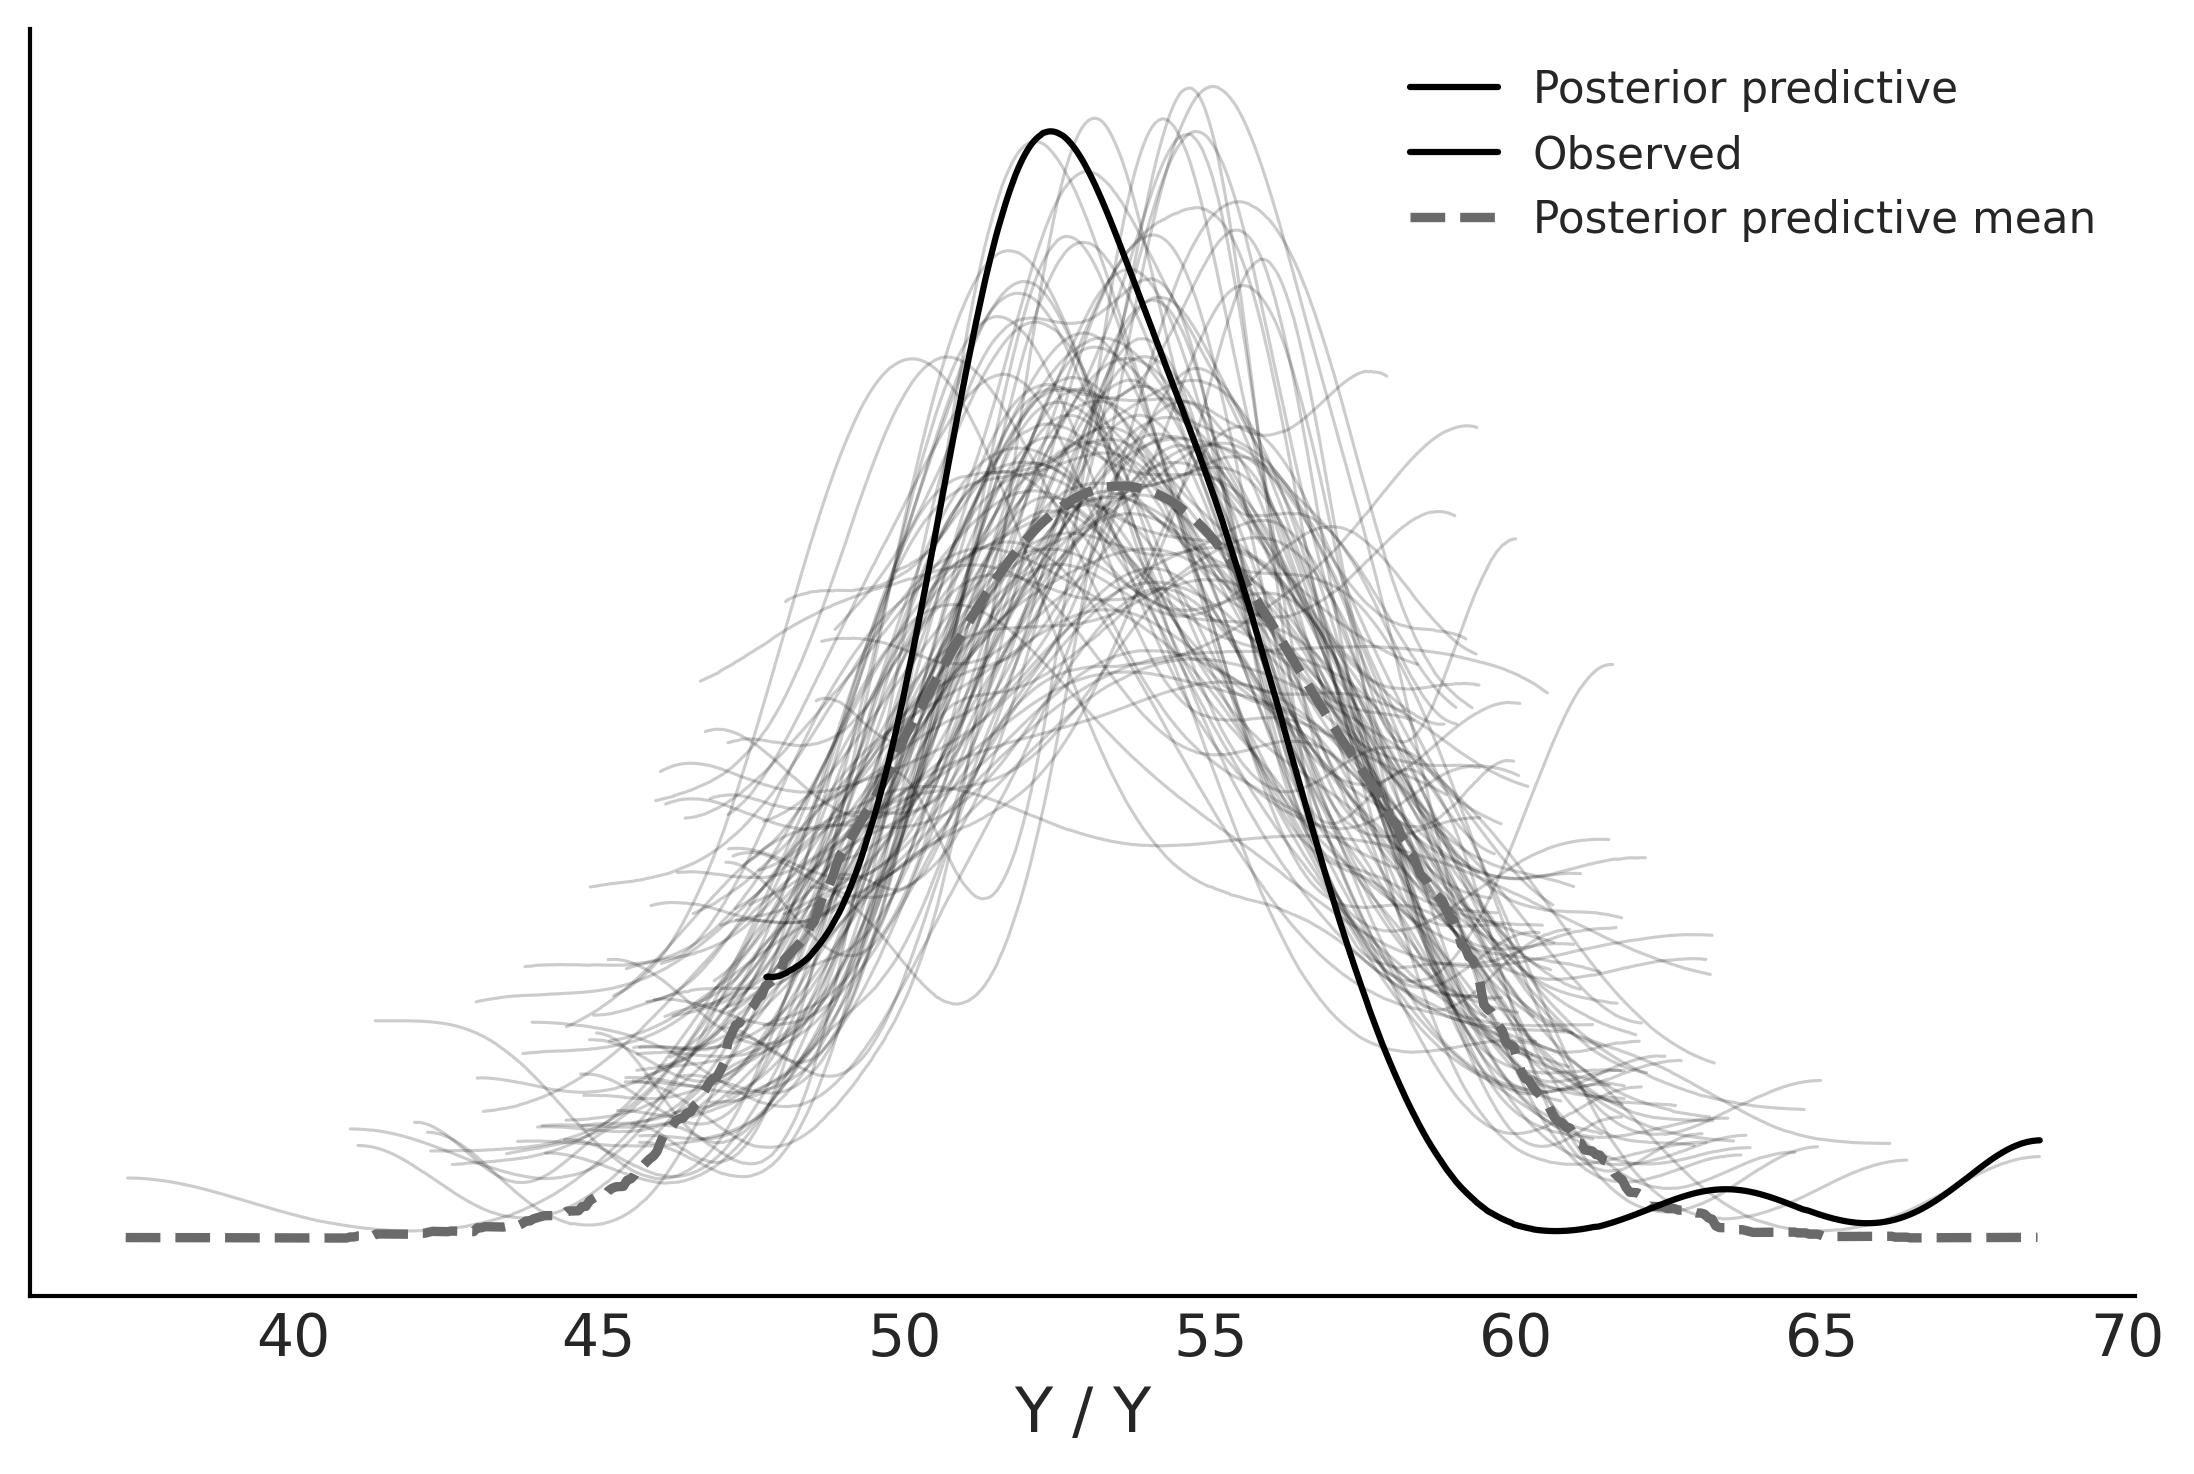

In [27]:
az.plot_ppc(idata_g, num_pp_samples=100)
plt.savefig("../fig/idata_g_ppc.png")